#### VirTues exmaple notebook
This notebook contains both the code to load a mutli-modal (SP + H&E) as well as the code to load and infer and image using VirTues. <br>

This is the general architecture overview of VirTues.

<img src="../resources/images/VirTues.png">

In [26]:
import sys
import os

# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 2. Add the project root to the list of places Python looks for modules
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print("OKK")

OKK


In [27]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from src.dataset.datasets.mm_base import build_mm_datasets
from src.utils.plot_utils import visualize_multichannel_image
from src.modules.flex_dual_virtues.flex_dual_virtues_new_init import build_flex_dual_virtues_encoder
from src.utils.marker_utils import load_marker_embeddings
from src.utils.utils import load_checkpoint_safetensors


In [28]:
import torch
print(f"Torch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

Torch version: 2.5.1+cu124
CUDA version: 12.4


In [29]:
base_cfg = OmegaConf.load("../src/dataset/configs/base_config.yaml")
base_cfg.marker_embedding_dir = "../src/dataset/esm2_t30_150M_UR50D"
marker_embeddings = load_marker_embeddings(base_cfg.marker_embedding_dir)
orion_subset_cfg = OmegaConf.load("../src/dataset/configs/orion_subset.yaml")
ds_cfg = OmegaConf.merge(base_cfg, orion_subset_cfg)

print("OK")

OK


/data/code/jon/project-2-gradient_tri_scent/src/utils/marker_utils.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings.append(torch.load(os.path.join(embedding_d

In [30]:
ds = build_mm_datasets(ds_cfg)

2025-12-01 09:59:32.617 | DEBUG    | src.dataset.datasets.mm_base:__init__:44 - Loading dataset orion from /data/virtues_orion_dataset/virtues_example/orion_subset
2025-12-01 09:59:32.621 | INFO     | src.dataset.datasets.multiplex_base:__init__:30 - Multiplex Normalization metadata: QuantileMultiplexNormalizeMetadata(normalizer_name='q_99', rnd_crop_folder_name='random_crops_256_no_log', channel_file_name='channels', mean_name='mean', std_name='std', quantile_path='quantiles/q99.csv')
2025-12-01 09:59:32.621 | INFO     | src.dataset.datasets.multiplex_base:__init__:30 - Multiplex Normalization metadata: QuantileMultiplexNormalizeMetadata(normalizer_name='q_99', rnd_crop_folder_name='random_crops_256_no_log', channel_file_name='channels', mean_name='mean', std_name='std', quantile_path='quantiles/q99.csv')
2025-12-01 09:59:32.644 | INFO     | src.dataset.datasets.multiplex_base:__init__:40 - Crop folder /data/virtues_orion_dataset/virtues_example/orion_subset/cycif/random_crops_256_no_

In [31]:
uniprot_to_name = ds[0].unimodal_datasets["cycif"].get_marker_embedding_index_to_name_dict()

Loading tissue 0: orion_zupwxfxb_0


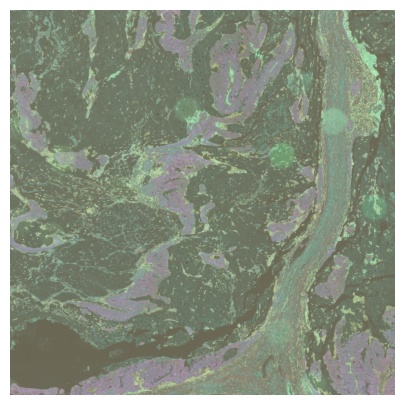

['CD31', 'CD45', 'CD68', 'CD4', 'FOXP3', 'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 'PD-1', 'Ki67', 'Pan-CK', 'SMA']
Loading tissue 1: orion_cxlhytpd_0
Loading tissue 2: orion_cnrgtuax_0
Loading tissue 2: orion_cnrgtuax_0
Loading tissue 3: orion_zgkkfgaw_0
Loading tissue 3: orion_zgkkfgaw_0
Loading tissue 4: orion_zcmsymch_0
Loading tissue 4: orion_zcmsymch_0
Loading tissue 5: orion_vkpuqrne_0
Loading tissue 5: orion_vkpuqrne_0
Loading tissue 6: orion_dmayaltl_0
Loading tissue 6: orion_dmayaltl_0
Loading tissue 7: orion_cxnlpalc_0
Loading tissue 7: orion_cxnlpalc_0
Loading tissue 8: orion_eljqkbji_0
Loading tissue 8: orion_eljqkbji_0
Loading tissue 9: orion_vsutyrqb_0
Loading tissue 9: orion_vsutyrqb_0
Loading tissue 10: orion_tkcdjcyi_0
Loading tissue 10: orion_tkcdjcyi_0
Loading tissue 11: orion_pzyzeozt_0
Loading tissue 11: orion_pzyzeozt_0
Loading tissue 12: orion_mabvrlfp_0
Loading tissue 12: orion_mabvrlfp_0
Loading tissue 13: orion_finlgcrv_0
Loading tissu

In [47]:
tids = ds[0].unimodal_datasets["cycif"].get_tissue_ids()

tissues = []
channel_ids = []

# Load more images (e.g., 20) instead of just 1
for i, tid in enumerate(tids):
    print(f"Loading tissue {i}: {tid}")
    # This function returns you a tensor which is normalized already according to the normalization selected in the base_config under image_info
    tissue = ds[0].unimodal_datasets["cycif"].get_tissue(tid)
    tissues.append(tissue)
    
    # Only visualize the first one to avoid clutter
    if i == 0:
        tissue_np = np.array(tissue)
        visualize_multichannel_image(tissue_np)
        plt.show()
        
    channels = np.array(ds[0].unimodal_datasets["cycif"].get_marker_embedding_indices(tid))
    channel_ids.append(channels)
    
    if i == 0:
        print(list(map(lambda x: uniprot_to_name[x], channels)))
        
    if i >= 19: # Load 20 images
        break

### Loading channel attention tokenizer

In [48]:
import pickle as pkl
# mx_tok_config = OmegaConf.load("channel_attn_tok.yaml")

with open(VIRTUES_WEIGHTS_PATH + "/config.pkl", "rb") as f:
    virtues_cfg = pkl.load(f)

virtues = build_flex_dual_virtues_encoder(virtues_cfg, marker_embeddings)
virtues.cuda()

weights = load_checkpoint_safetensors(VIRTUES_WEIGHTS_PATH + "/checkpoints/checkpoint-94575/model.safetensors")
# rename weights
weights_encoder = {}
for k, v in weights.items():
    if k.startswith("encoder."):
        weights_encoder[k[len("encoder."):]] = v

virtues.load_state_dict(weights_encoder, strict=False)

2025-12-01 10:09:26.890 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:128 - Using protein embedding: esm with shape torch.Size([213, 640])
2025-12-01 10:09:26.893 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add
2025-12-01 10:09:26.893 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add


_IncompatibleKeys(missing_keys=[], unexpected_keys=['encoder.0.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.0.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.2.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.2.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.4.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.4.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.6.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.6.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.8.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.8.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.10.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.10.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.12.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.12.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encod

In [49]:
param_count = sum(p.numel() for p in virtues.parameters())
print(f"Number of parameters in virtues encoder: {param_count/1e6:.2f}M")

Number of parameters in virtues encoder: 34.11M


In [50]:
mx_images = [torch.tensor(tissue).cuda(non_blocking=True) for tissue in tissues]
mx_channel_ids = [torch.tensor(channels).cuda(non_blocking=True) for channels in channel_ids]

# use 224x224 crop size
mx_images = [tissue[:, :128, :128] for tissue in mx_images]

with torch.autocast(device_type='cuda', dtype=torch.float16):
    channel_tokens, pss  = virtues.forward_list(mx_images, [None] * len(mx_images), mx_channel_ids)
    pss = torch.stack(pss)

/tmp/ipykernel_8214/2848231403.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mx_images = [torch.tensor(tissue).cuda(non_blocking=True) for tissue in tissues]


In [51]:
pss.shape

torch.Size([20, 16, 16, 512])

## Usage of Decoder to Visualize Data

Running decoder...
Visualizing image index: 7
Model Patch Size: 8 (This causes the blocky grid artifacts)

--- Composite Visualization ---


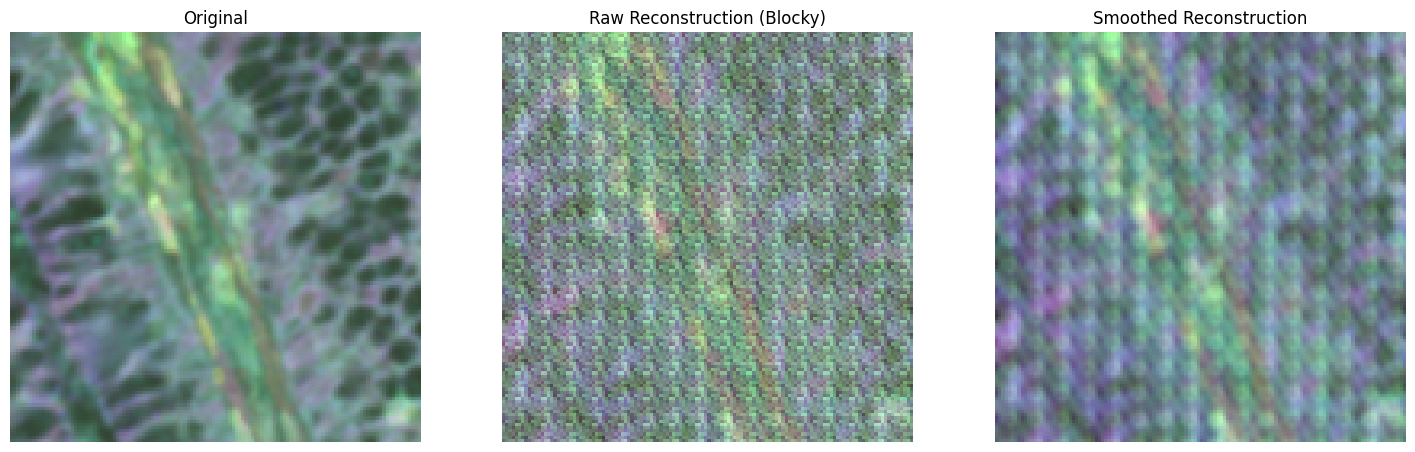


--- Channel-wise Breakdown (First 5 Channels) ---


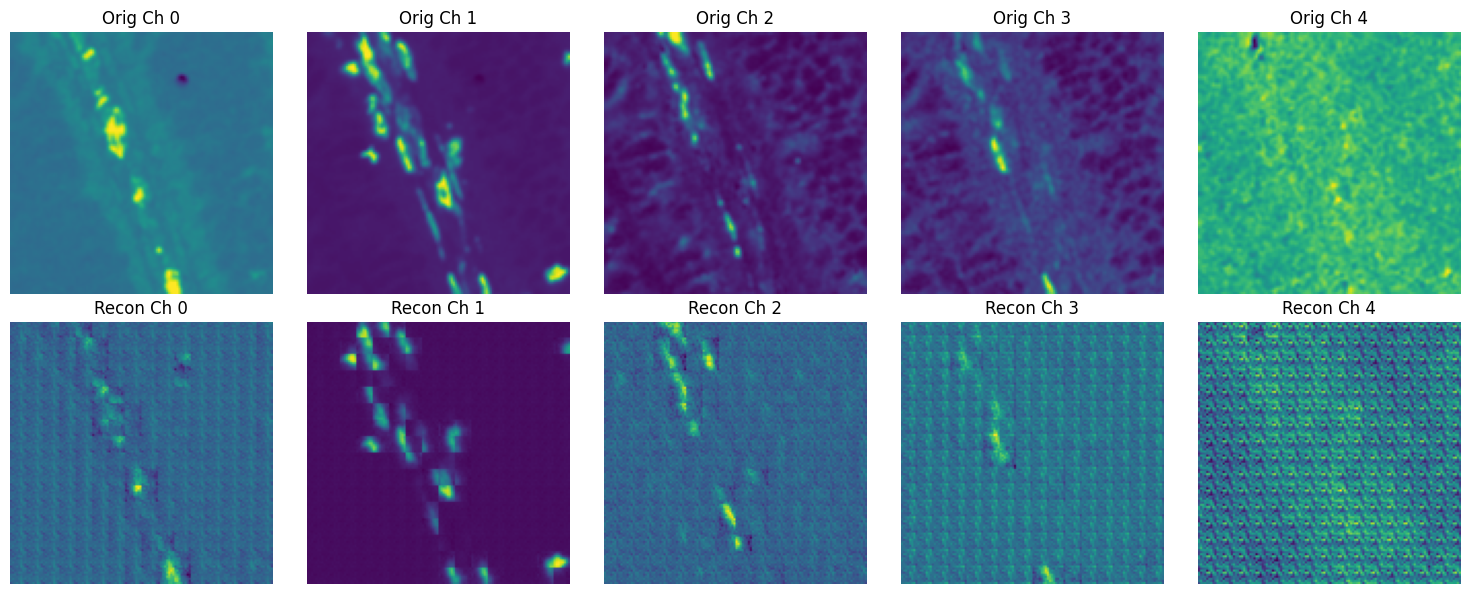

In [63]:
import random
from src.modules.flex_dual_virtues.flex_dual_virtues_new_init import build_flex_dual_virtues

# 1. Build the full model
if 'full_model' not in locals():
    full_model = build_flex_dual_virtues(virtues_cfg, marker_embeddings)
    full_model.cuda()
    msg = full_model.load_state_dict(weights, strict=False)
    print(f"Full model loaded with status: {msg}")

# 2. Prepare inputs
if 'pss' not in locals() or 'channel_tokens' not in locals():
    raise ValueError("Please run the encoder cell above to generate 'pss' and 'channel_tokens' first.")

ps_list = [p for p in pss] 
multiplex_channels_per_sample = [len(c) for c in mx_channel_ids]
he_channels_per_sample = [0] * len(mx_images)

# 3. Run Decoder
print("Running decoder...")
with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
    reconstructed_mpx, reconstructed_he = full_model.mae_decoder.forward_list(
        channel_tokens, 
        ps_list, 
        multiplex_channels_per_sample, 
        he_channels_per_sample
    )

# 4. Visualize & Analyze
if len(mx_images) > 0:
    idx = random.randint(0, len(mx_images) - 1)
    print(f"Visualizing image index: {idx}")
    
    # Check patch size for explanation
    patch_size = virtues_cfg.image_info.patch_size if hasattr(virtues_cfg, 'image_info') else "Unknown"
    print(f"Model Patch Size: {patch_size} (This causes the blocky grid artifacts)")

    orig = mx_images[idx].float().cpu().numpy()
    recon = reconstructed_mpx[idx].float().cpu().numpy()

    # Composite Visualization
    print("\n--- Composite Visualization ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    visualize_multichannel_image(orig, ax=axes[0], title="Original")
    visualize_multichannel_image(recon, ax=axes[1], title="Raw Reconstruction (Blocky)")
    # Apply Gaussian smoothing to hide patch artifacts
    visualize_multichannel_image(recon, ax=axes[2], title="Smoothed Reconstruction", apply_gaussian=True)
    
    plt.show()

    # Channel-wise Visualization
    print("\n--- Channel-wise Breakdown (First 5 Channels) ---")
    num_channels_to_show = min(5, orig.shape[0])
    fig, axes = plt.subplots(2, num_channels_to_show, figsize=(3*num_channels_to_show, 6))
    
    for c in range(num_channels_to_show):
        # Original
        ax_orig = axes[0, c]
        im_orig = ax_orig.imshow(orig[c], cmap='viridis')
        ax_orig.set_title(f"Orig Ch {c}")
        ax_orig.axis('off')
        
        # Recon
        ax_recon = axes[1, c]
        im_recon = ax_recon.imshow(recon[c], cmap='viridis')
        ax_recon.set_title(f"Recon Ch {c}")
        ax_recon.axis('off')
        
    plt.tight_layout()
    plt.show()
else:
    print("No images available.")